![logoSBCAS](http://www.midiacom.uff.br/sbcas2019/wp-content/uploads/2018/11/logo.png) 
# Mini-curso: Machine Learning aplicado à Saúde




Autores:

Prof. Dr. André Filipe de Moraes Batista (USP)

Prof. Dr. Alexandre Chiavegatto Filho (USP)



---



## 1. Sobre o conjunto de dados

As doenças cardiovasculares são uma das principais causas de morte nos Estados Unidos, sendo contabilizadas em mais de 30% das ocorrências anuais. Quando detectadas precocemente podem reduzir os ataques cardíacos em 80%, assim como  a mortalidade em 45% (LADERAS et al., 2018).  


Na busca por fomentar o acesso a base de dados clínicos que possam auxiliar no desenvolvimento de modelos preditivos para tais doenças Laderas et al. (2018) criaram um conjunto de dados sintéticos de modo a possibilitar o desenvolvimento de modelos preditivos para doenças cardiovasculares. Para a elaboração do conjunto de dados, buscou-se incluir dependências realísticas entre as variáveis (por exemplo, pacientes com alto índice de massa corpórea (IMC) têm maior prevalência de diabetes tipo 2), bem como buscou-se apresentar baixa prevalência da doença para determinadas coortes (pessoas com menos de 40 anos, por exemplo).  O conjunto de dados sintético possui 425.195 instâncias e as variáveis disponíveis estão apresentadas na tabela abaixo.

![alt text](https://i.ibb.co/1dPXd7N/image.png) 

## 2. Importação de bibliotecas

2.1 Instalação de pacotes adicionais

In [ ]:
!pip install dfply ## instala o pacote DFPLY
!pip install scikit-plot ## instala o pacote SCIKIT-PLOT
!pip install xgboost
!pip install graphviz
##!pip install python-graphviz

!pip install dtreeviz
!pip install pandas-profiling

    100% |████████████████████████████████| 614kB 12.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/4c/3f/87/b2c828617d1bd181145fbaf41129e4c82fa8d9a98082701e00
Successfully built dtreeviz


2.2 Importação de bibliotecas

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

### biblioteca SCIKIT-LEARN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


import random

from dfply import *

import scikitplot as skplt

from dtreeviz.trees import *

import pandas_profiling


import warnings
warnings.filterwarnings("ignore")

## 3. Obtendo o conjunto de dados

In [ ]:
dataset = pd.read_csv('https://raw.githubusercontent.com/laderast/cvdRiskData/master/data-raw/fullPatientData.csv')

3.1 Verificando o conjunto de dados

In [ ]:
dataset.shape

(425195, 13)

In [ ]:
dataset.head(5)

,patientID,age,htn,treat,smoking,race,t2d,gender,numAge,bmi,tchol,sbp,cvd
0,HHUID00076230,20-40,Y,Y,N,Asian/PI,N,M,21,26,176,179,N
1,HHUID00547835,70-90,N,N,N,White,N,M,86,23,244,123,N
2,HHUID00450841,20-40,Y,Y,N,White,N,M,29,22,189,165,N
3,HHUID00380788,20-40,Y,Y,N,White,N,M,24,24,218,172,N
4,HHUID00043423,20-40,N,N,N,Asian/PI,N,M,40,20,207,111,N


In [ ]:
profile = pandas_profiling.ProfileReport(dataset)

In [ ]:
profile

Number of variables,13
Number of observations,425195
Total Missing (%),0.0%
Total size in memory,42.2 MiB
Average record size in memory,104.0 B
Numeric,4
Categorical,8
Boolean,0
Date,0
Text (Unique),1
Rejected,0


## 4. Preparação do conjunto de dados

4.1 Filtrando o conjunto de dados

Para os modelos preditivos a serem desenvolvidos neste mini-curso, iremos considerar individuos com idade superior a 55 anos.
Removeremos também as variáveis "patientID", "age" e "treat" 

In [ ]:
cvd_data = (dataset >>
               mask(X.numAge > 55) >>
               drop(X.patientID, X.age, X.treat)
              )

In [ ]:
cvd_data.head(5)

,htn,smoking,race,t2d,gender,numAge,bmi,tchol,sbp,cvd
1,N,N,White,N,M,86,23,244,123,N
7,N,N,White,N,M,59,23,178,113,N
10,N,N,Asian/PI,N,M,69,19,181,118,N
11,Y,Y,White,N,M,56,21,188,183,N
12,N,N,White,N,M,64,16,240,111,N


In [ ]:
cvd_data.shape

(125335, 10)

4.2 Para as variáveis categóricas iremos criar dummies

In [ ]:
cvd_data = pd.get_dummies(cvd_data, columns=['htn', 'smoking', 't2d', 'gender', 'race'])

In [ ]:
cvd_data.head(10)

,numAge,bmi,tchol,sbp,cvd,htn_N,htn_Y,smoking_N,smoking_Y,t2d_N,t2d_Y,gender_F,gender_M,race_AmInd,race_Asian/PI,race_Black/AfAm,race_White
1,86,23,244,123,N,1,0,1,0,1,0,0,1,0,0,0,1
7,59,23,178,113,N,1,0,1,0,1,0,0,1,0,0,0,1
10,69,19,181,118,N,1,0,1,0,1,0,0,1,0,1,0,0
11,56,21,188,183,N,0,1,0,1,1,0,0,1,0,0,0,1
12,64,16,240,111,N,1,0,1,0,1,0,0,1,0,0,0,1
32,66,22,241,140,Y,1,0,1,0,1,0,0,1,0,0,0,1
33,82,20,206,204,Y,0,1,1,0,1,0,0,1,0,0,0,1
35,56,16,245,123,N,1,0,1,0,1,0,0,1,0,0,0,1
36,58,16,244,179,N,0,1,1,0,1,0,0,1,0,0,0,1
37,80,23,207,124,N,1,0,1,0,1,0,0,1,0,0,0,1


## 5. Conjuntos de treino e teste

In [ ]:
variaveis_preditoras = cvd_data.iloc[:, cvd_data.columns != 'cvd']
classe = cvd_data.iloc[:, cvd_data.columns == 'cvd']
X_train, X_test, y_train, y_test = train_test_split(variaveis_preditoras, 
                                                    classe,
                                                    train_size = 0.70,
                                                    random_state = 42)




In [ ]:
X_train_columns = X_train.columns

Verificando a distribuição da classe  conjunto de treino e teste

In [ ]:
### transformando Y --> 1 e N --> 0 
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
plt.hist(y_train)

(array([63144.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 24590.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

In [ ]:
plt.hist(y_test)

(array([26964.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10637.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

5.1 As variáveis contínuas serão padronizadas

In [ ]:
from sklearn.compose import ColumnTransformer

### variáveis contínuas que serão padronizadas
continuous_cols = ['numAge', 'bmi', 'tchol', 'sbp']


def setScaler():
  ct = ColumnTransformer([
        ('scaler', StandardScaler(), continuous_cols)
    ], remainder='passthrough'
  )
  return ct
  
scaler = setScaler()

In [ ]:
scaler.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True), ['numAge', 'bmi', 'tchol', 'sbp'])])

In [ ]:
X_train = scaler.transform(X_train)

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
pd.DataFrame(X_train, columns=X_train_columns).head(10)

,numAge,bmi,tchol,sbp,htn_N,htn_Y,smoking_N,smoking_Y,t2d_N,t2d_Y,gender_F,gender_M,race_AmInd,race_Asian/PI,race_Black/AfAm,race_White
0,1.273356,-1.347215,-0.859665,1.195618,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.659311,0.247619,-0.453873,0.531070,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.196162,-0.435881,0.695870,0.531070,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.736504,-0.663715,-0.487689,-0.734736,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.122459,-0.208048,1.338374,-1.367639,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,-1.088792,2.981619,1.879430,1.512070,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,-0.015088,-1.119381,-0.994929,1.353844,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,0.521763,-0.208048,0.087183,1.227263,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,0.092282,0.019786,0.154814,-0.798026,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9,-0.551940,-1.119381,0.154814,0.784231,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## 6. Função auxiliar RunModel

In [ ]:
def runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title="", pos_label=1):
    """Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor de y_train e y_test que representa a classe positiva. O valor default é 1. 

    """
    clf = model
    name = title
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
        
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    if confusion_matrix:
       skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=normalizeCM, title=name)
    if roc:
       skplt.metrics.plot_roc(y_test, prob_pos, plot_micro=False, plot_macro=False, classes_to_plot=[1], title=name,figsize=(10,10))
     
            
    prob_pos = prob_pos[:,1]
    clf_score = brier_score_loss(y_test, prob_pos, pos_label=pos_label)
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))
        
    if plot_calibration:
      
      fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_test, prob_pos, n_bins=10)
      plt.rcParams.update({'font.size': 22})
      plt.rc('legend',**{'fontsize':22})
      fig = plt.figure(3, figsize=(10, 10))
      ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
      ax2 = plt.subplot2grid((3, 1), (2, 0))
      ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado",)
      ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))

      ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                     histtype="step", lw=2)

      ax1.set_ylabel("Fração de positivos")
      ax1.set_ylim([-0.05, 1.05])
      ax1.legend(loc="lower right")
      ax1.set_title('Gráfico de Calibração  (reliability curve)')
      
      ax2.set_xlabel("Valor médio predito")
      ax2.set_ylabel("Quantidade")
      ax2.legend(loc="upper center", ncol=2)
      
      for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)
        
      for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(22)
      
      plt.tight_layout()
      plt.show()
    
    
    

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
help(runModel)

Help on function runModel in module __main__:

runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title='', pos_label=1)
    Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor

## Execução dos algoritmos de machine learning

### 1. Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()

Regressão Logística:
	Brier: 0.163
	Precision: 0.629
	Recall: 0.363
	F1: 0.460



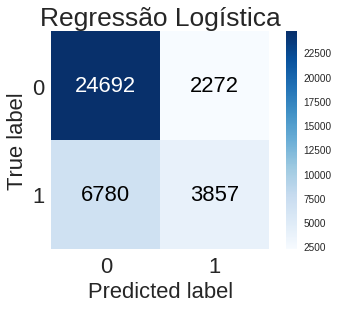

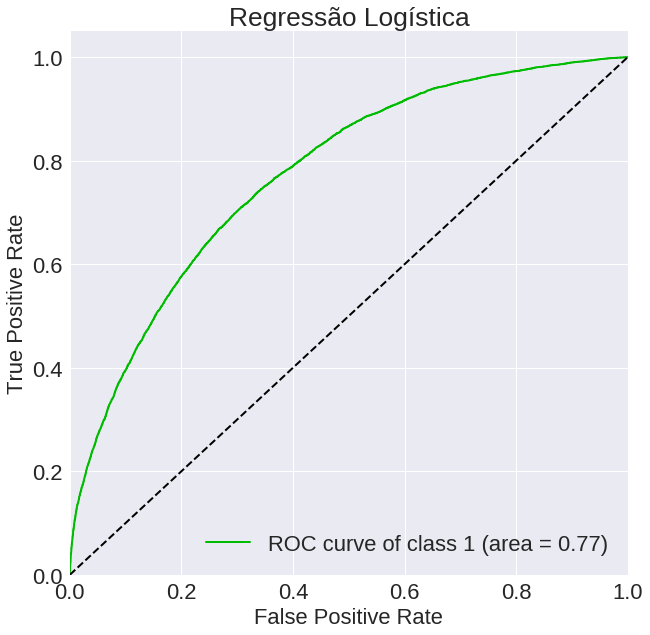

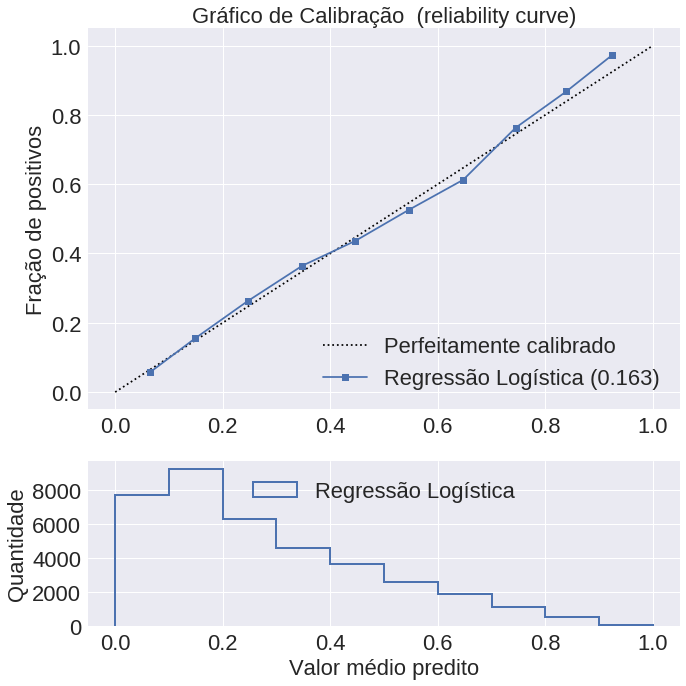

In [ ]:
runModel(lr, X_train, y_train, X_test, y_test, title="Regressão Logística")

### 2. Árvore de Decisão

Grid Search

In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2,5,8,15,20],
              "max_depth": [2,4,6,8,10],
              "min_samples_leaf": [1,2,4,8,10],
              "max_leaf_nodes": [2,4, 7,9, 12, 20],
              }
dt = DecisionTreeClassifier(random_state=42)
cv_dt = GridSearchCV(dt, cv = 3,
                     param_grid=param_grid,
                     n_jobs = -1)

In [ ]:
cv_dt.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 8, 15, 20], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 8, 10], 'max_leaf_nodes': [2, 4, 7, 9, 12, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
cv_dt

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 8, 15, 20], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 8, 10], 'max_leaf_nodes': [2, 4, 7, 9, 12, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
report(cv_dt.cv_results_)

Model with rank: 1
Mean validation score: 0.755 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.755 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.755 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 8}

Model with rank: 1
Mean validation score: 0.755 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 15}

Model with rank: 1
Mean validation score: 0.755 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.755 (std: 0.001)
Parameters: {'cri

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=20)

Árvore de Decisão:
	Brier: 0.169
	Precision: 0.617
	Recall: 0.311
	F1: 0.414



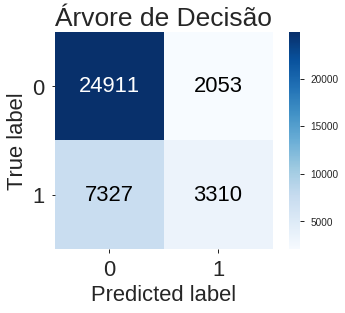

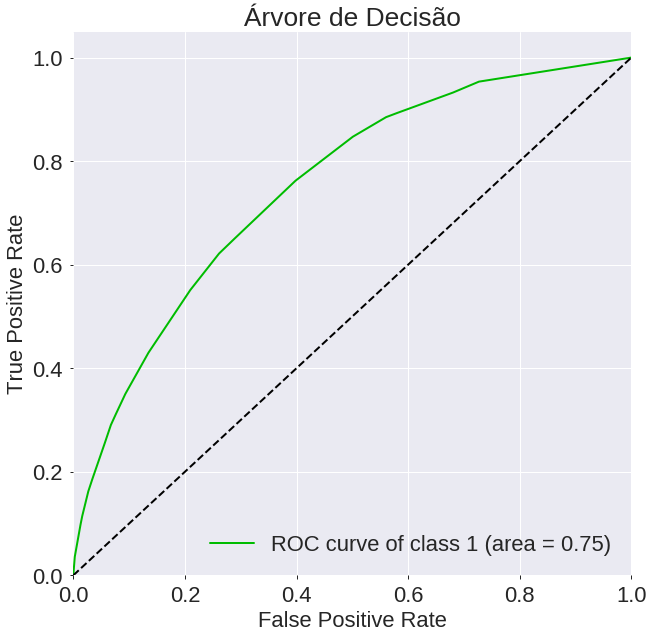

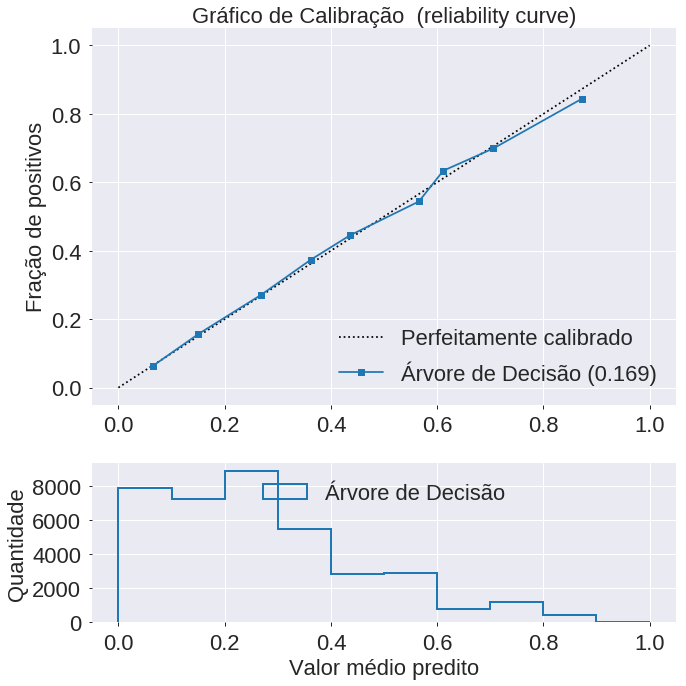

In [ ]:
runModel(dt, X_train, y_train, X_test, y_test, title="Árvore de Decisão")

In [ ]:
viz = dtreeviz(dt,
               X_train,
               y_train,
               target_name='cvd',
               feature_names=X_train_columns,
               class_names=["N", "Y"])

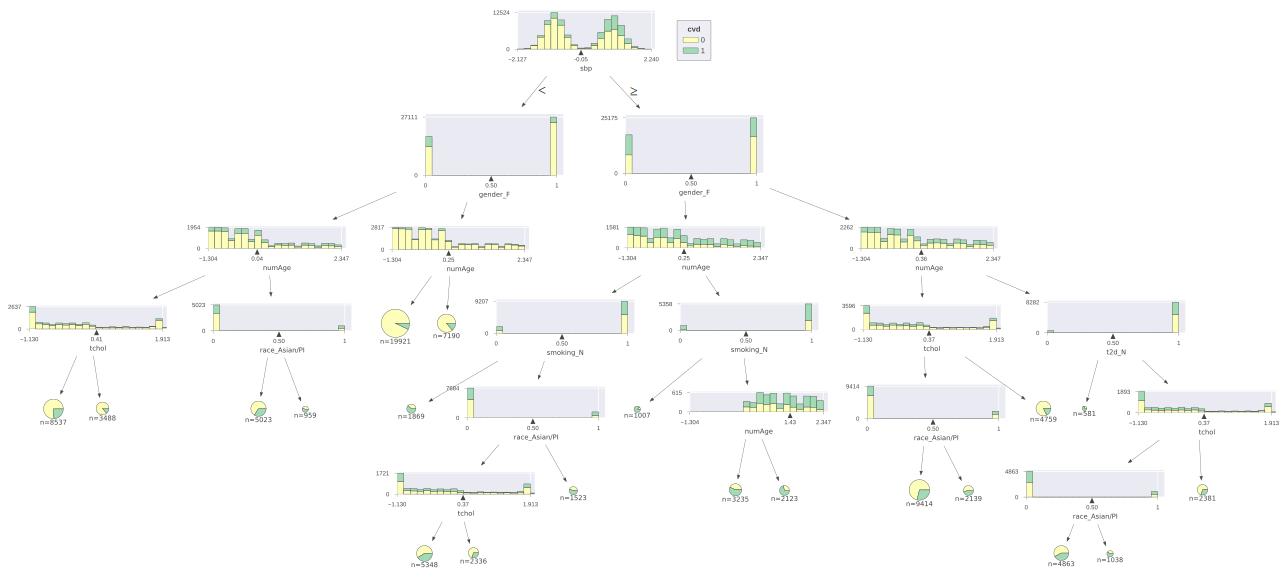

In [ ]:
viz

In [ ]:
viz = dtreeviz(dt,
               X_train,
               y_train,
               target_name='cvd',
               feature_names=X_train_columns,
               class_names=["N", "Y"],
               orientation= 'LR',
               X=X_test[np.random.randint(0, len(X_test))])


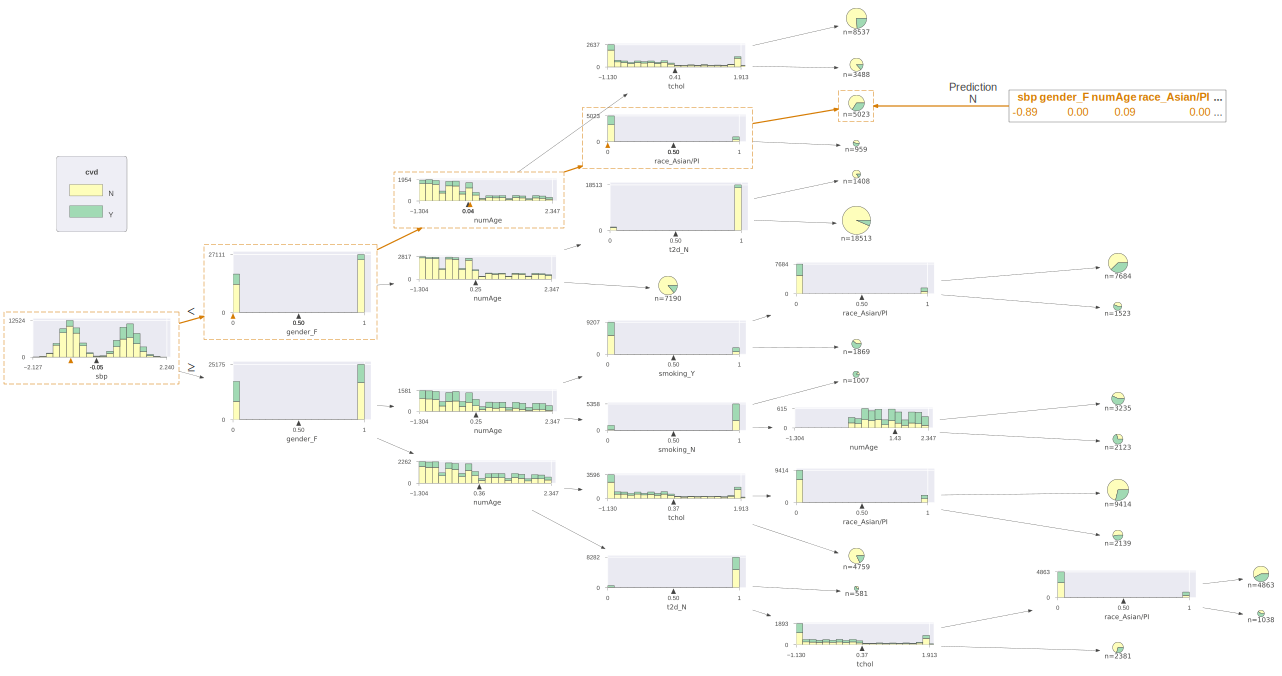

In [ ]:
viz

## Random Forest

In [ ]:
# criando a random forest

fit_rf = RandomForestClassifier(random_state=42, verbose=1)



In [ ]:
np.random.seed(42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Caso deseje rodar GridSearchCV, troque a linha acima pela que segue

cv_rf = GridSearchCV(fit_rf, cv=3, param_grid=param_grid,
                     n_jobs = -1) 

cv_rf = RandomizedSearchCV(fit_rf, n_iter=50, cv=3, verbose=1, param_distributions=param_grid,
                     n_jobs = -1)



In [ ]:
cv_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 95.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 144.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:   53.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=1, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [100, 325, 550, 775, 1000], 'max_features': ['log2', 'sqrt'], 'max_depth': [5, 8, 12, 16, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=5)

In [ ]:
rf = cv_rf.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:   54.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:    3.3s finished


Random Forest:
	Brier: 0.162
	Precision: 0.643
	Recall: 0.342
	F1: 0.447



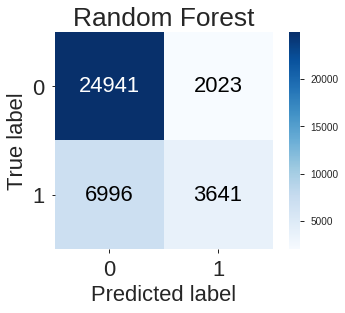

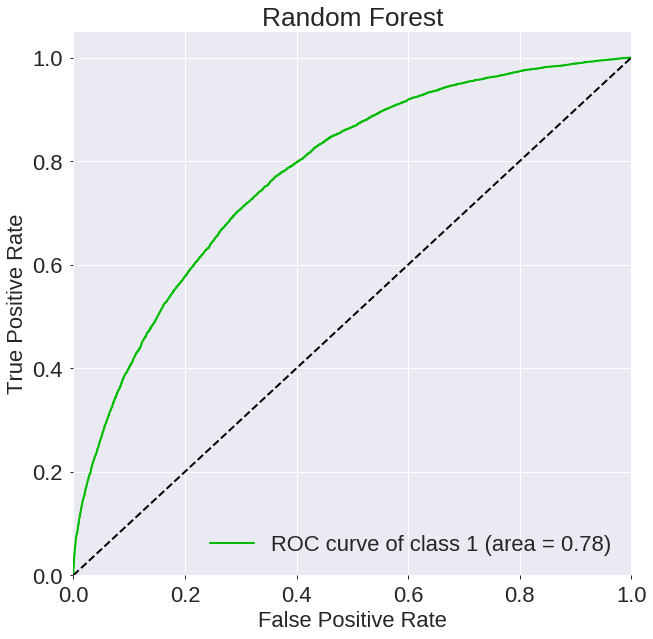

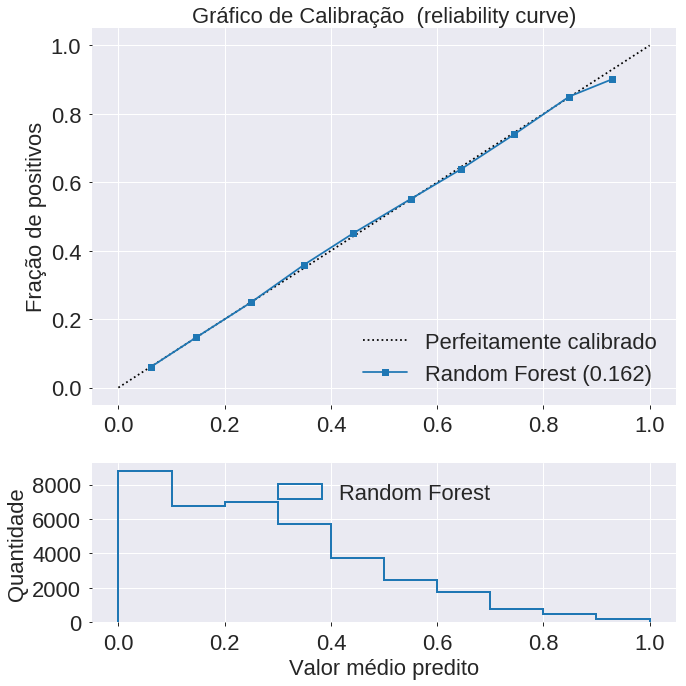

In [ ]:
runModel(rf, X_train, y_train, X_test, y_test, title="Random Forest")

## XGBoost Classifier


In [ ]:
### XGBOOST
params_xgb = {
        'learning_rate': [0.02, 0.03,0.04],
        'n_estimators': [500,700,800],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5,10,20,40]
        }

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',silent=True, nthread=-1)

In [ ]:
gridXGB = GridSearchCV(xgb, param_grid=params_xgb,
                              scoring="roc_auc", n_jobs=-1, cv=5, verbose=1)

In [ ]:
gs = gridXGB.fit(X_train, y_train)

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 88.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 426.1min


In [ ]:
results = best_xgb_model.predict(x_test, ntree_limit=best_xgb_model.best_ntree_limit)

In [ ]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=60, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

XGBoost:
	Brier: 0.162
	Precision: 0.646
	Recall: 0.343
	F1: 0.448



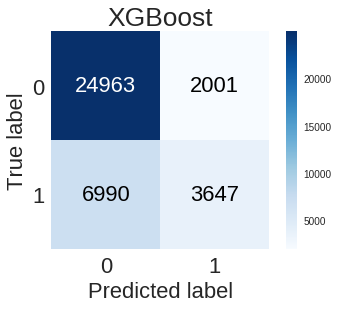

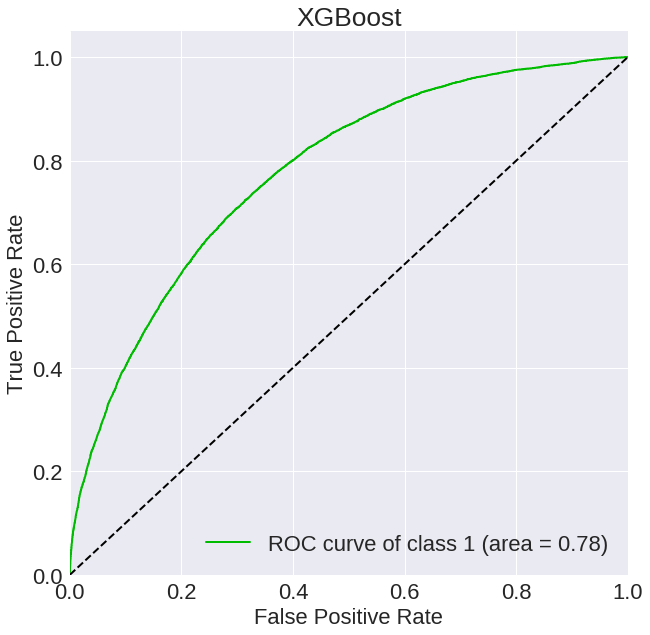

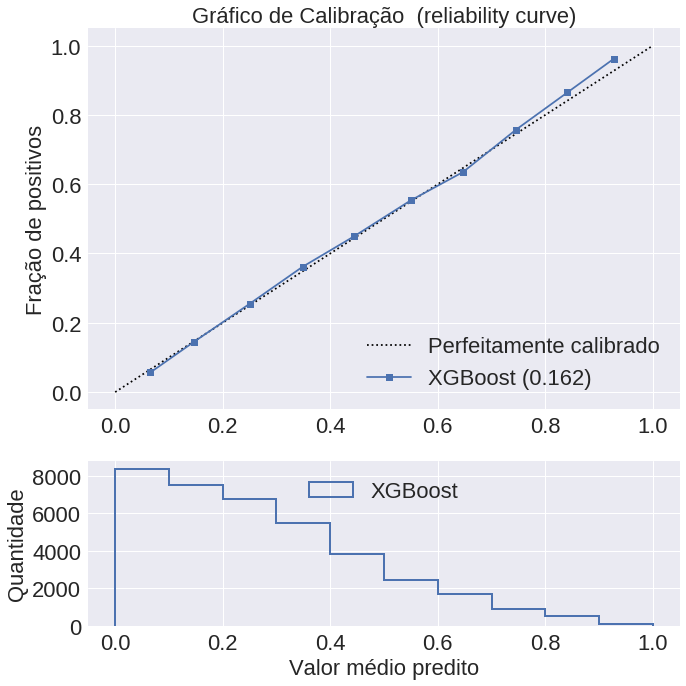

In [ ]:
runModel(xgb, X_train, y_train, X_test, y_test, title="XGBoost")

In [ ]:
from sklearn import neural_network

parameters_rna = {'activation':['relu', 'tanh'],
                  'solver': ['adam', 'lbfgs', 'sgd'],
                  'max_iter': [500,1000], 
                  'alpha': 10.0 ** -np.arange(1, 3), 
                  'hidden_layer_sizes':[2,3,5,7], 
                  'batch_size':np.arange(5,15,32),
                  'learning_rate_init':[0.01, 0.03, 0.1] }

rna = neural_network.MLPClassifier(verbose=True)




clf_grid_rna = GridSearchCV(rna, parameters_rna, n_jobs=-1, scoring='roc_auc')

In [ ]:
clf_grid_rna.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'activation': ['relu', 'tanh'], 'solver': ['adam', 'lbfgs', 'sgd'], 'max_iter': [500, 1000], 'alpha': array([0.1 , 0.01]), 'hidden_layer_sizes': [2, 3, 5, 7], 'batch_size': array([5]), 'learning_rate_init': [0.01, 0.03, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [ ]:
clf_grid_rna.best_estimator_

In [ ]:
from sklearn import neural_network

In [ ]:
rna = neural_network.MLPClassifier(activation='tanh', alpha=0.1, batch_size=5, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=7, learning_rate='constant',
       learning_rate_init=0.1, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

RNA:
	Brier: 0.162
	Precision: 0.645
	Recall: 0.340
	F1: 0.446



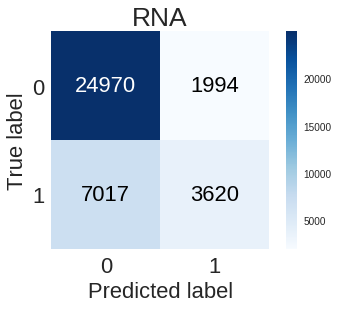

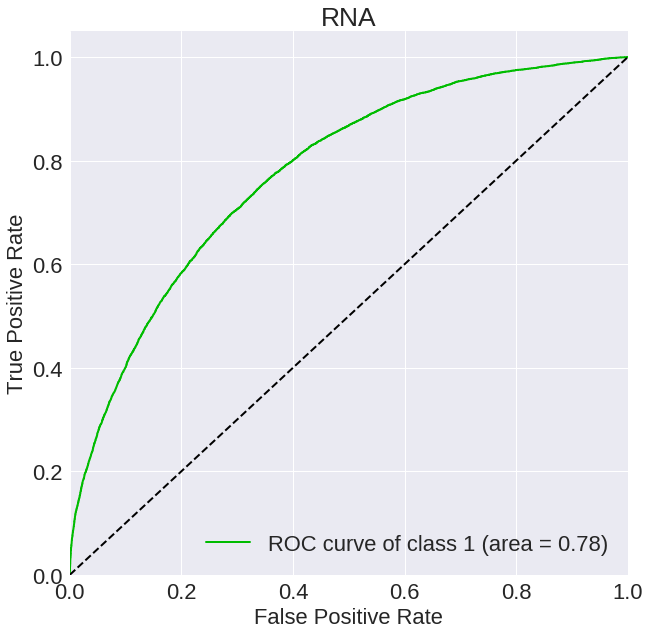

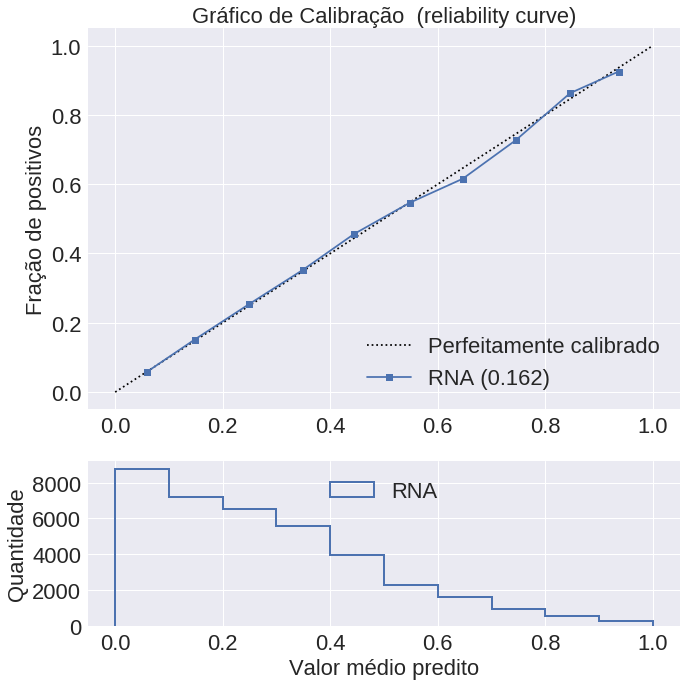

In [ ]:
runModel(rna, X_train, y_train, X_test, y_test, title="RNA")

In [ ]:
from sklearn.svm import SVC
  
clf = SVC(gamma='auto')

In [ ]:
runModel(clf, X_train, y_train, X_test, y_test, title="SGD")

In [ ]:
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
np.arange(3,31,2)

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
grid_params = {
	'n_neighbors': np.arange(3,31,2),
	'weights': ['uniform', 'distance'],
	'metric': ['euclidean', 'manhattan']
}
gs = GridSearchCV(neigh, param_grid=grid_params, scoring='roc_auc',cv=3)

In [ ]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [ ]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=21, p=2,
           weights='uniform')

KNN:
	Brier: 0.168
	Precision: 0.602
	Recall: 0.359
	F1: 0.450



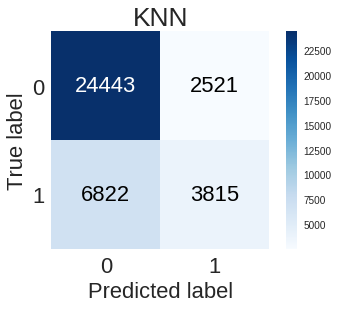

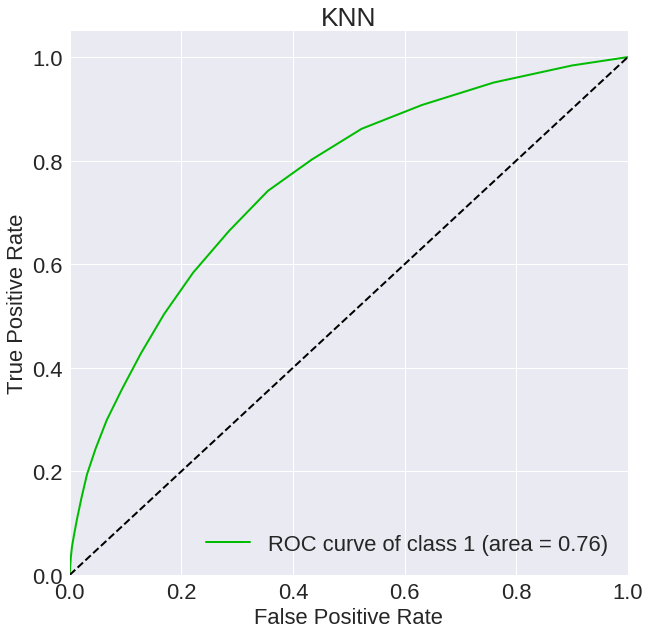

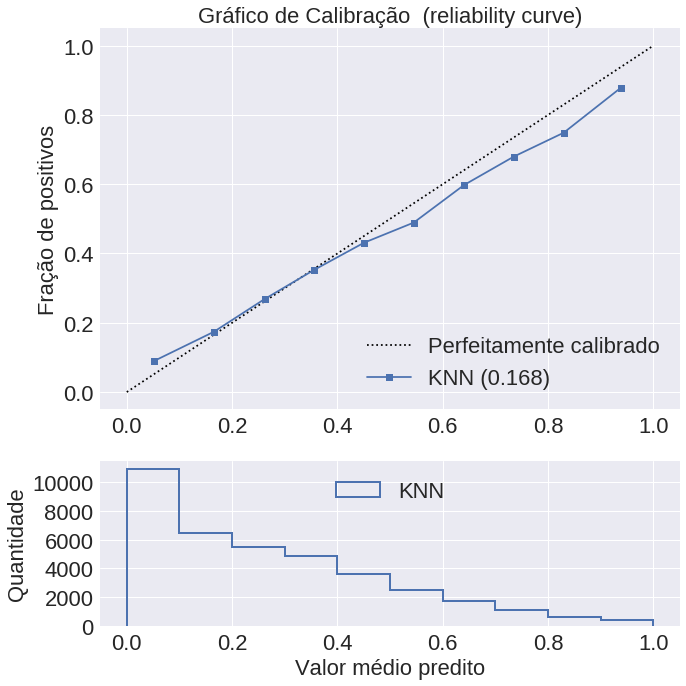

In [ ]:
runModel(gs.best_estimator_, X_train, y_train, X_test, y_test, title="KNN")

In [ ]:
### FINAL
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=59, p=2,
           weights='uniform')

KNN:
	Brier: 0.164
	Precision: 0.633
	Recall: 0.349
	F1: 0.449



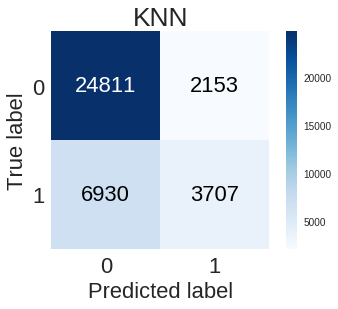

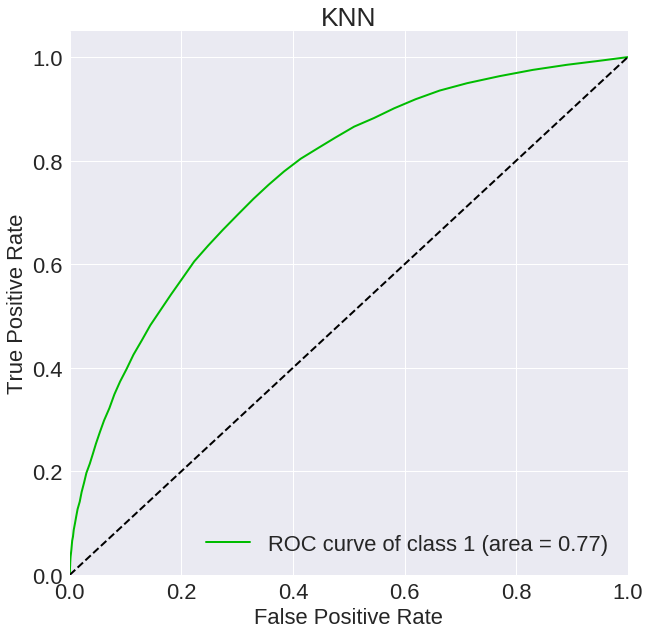

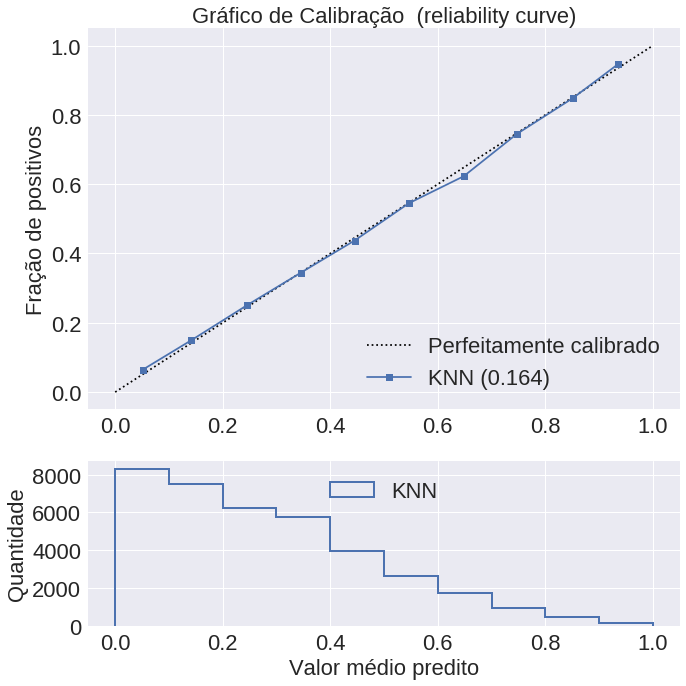

In [ ]:
runModel(knn, X_train, y_train, X_test, y_test, title="KNN")